In [225]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact, fixed

## Non-Parametric Methods 

- KDE
- k-NN
- k-means

So far, we've been assuming a hypothesis class & the types of parameters 

| Algorithm | Class | Parameters |
| --- | --- | --- |
| Perceptron | Linear (sign) | $w, b$ |
| Linear Regression | Linear | $w, b$ |
| Gaussian Distribution | Gaussian PDF | $\mu, \sigma$ |


But, this approach does not work for all problems. 
- e.g. What if the data is not linearly separable?
- e.g. What if the data is not Gaussian?

In such cases, we can use non-parametric methods.

## Parametric vs. Non-Parametric Methods

| | Parametric | Non-Parametric |
| --- | --- | --- |
| Assumptions about data | Yes | No |
| Complexity of the model | model=equation | model=set of clusters |
| Adaptability to new data | No | Yes |
| Data efficiency | Yes | No |

## Kernel (Parzen) Density Estimation (KDE)

*Learning a distribution without a hypothesis class*

Given: set of observations: $x_1, x_2, \ldots, x_n$
Idea: drop a *kernel* at each point. More overlap = more density.

Parzen estimate for probability density at some query point $x_o$:

$$
\hat{p}_X(x_o) = \frac{1}{n\lambda} \sum_{i=1}^n K_\lambda(x_o - x_i)
$$

where $K_\lambda$ is the kernel function

$\lambda$ is the length-scale parameter (how much smoothing)

---

$K$ interpolates between $x_1$ and $x_0$. By doing this over all points, we get the density at the query point, x_0.

If we do this for enough points, we can see the density of the data.


---

### Kernel Functions 

Rules: 
1. Non-negative 
2. Symmetric
3. Integrates to 1

In [ ]:
# Example - Non Seperable data
from sklearn.neighbors import KernelDensity

# TEST DATA (non-separable)
n = 100     # number of data points
radius = 3
x_1 = np.random.normal(0, radius, n)
x_2 = np.random.normal(0, radius, n)
D = pd.DataFrame({'x_1': x_1, 'x_2': x_2})

# "Drop" a kernel function at each point. Plot the resulting density estimate over top of the scatter plot of x1 vs. x2.
def plot_kde_bandwidth(bandwidth, data, kernelType: str):
    kde = KernelDensity(kernel=kernelType, bandwidth=bandwidth).fit(data)
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    xy_sample = np.vstack([X.ravel(), Y.ravel()]).T
    log_dens = kde.score_samples(xy_sample) # Compute the log-likelihood of each sample under the model.
    Z = np.exp(log_dens).reshape(X.shape)

    plt.contourf(X, Y, Z, levels=20, cmap='Blues')
    plt.colorbar(label='Density')
    plt.scatter(data[:, 0], data[:, 1], c='red', s=5)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.show()

    # plot the distribution of 'kernelType'
    plt.figure(figsize=(10, 5))
    plt.plot(x, Z[50, :])
    plt.title(f'Density of {kernelType} kernel')

# Convert DataFrame to numpy array
data = D[['x_1', 'x_2']].values

# Use interact to create an interactive plot
interact(plot_kde_bandwidth, bandwidth=(0.1, 2.0, 0.1), data=fixed(data), kernelType=['gaussian', 'tophat', 'cosine', 'linear', 'exponential'])

In [ ]:
# TEST DATA (non-separable)
n = 100     # number of data points
radius = 3
x1 = np.random.normal(0, radius, n)
x2 = np.random.normal(0, radius, n)
D = pd.DataFrame({'x_1': x1, 'x_2': x2})

plt.scatter(x1, x2)


def kernel(x0, x1):
    return np.exp( - sum((x0 - x1)**2) / 2) # Gaussian kernel

def ParzenDensity(x0, kernel, D):
    return sum(kernel(x0, x1) for x1 in D.values) / D.size

# create a 3d array: x * y * PDE
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = ParzenDensity([X[i, j], Y[i, j]], kernel, D)
plt.imshow(Z, extent=[-10, 10, -10, 10], origin='lower')

If you don't have a reference distribution (for the data), we can use KDE to fit a distribution to the data.

Example: 

| 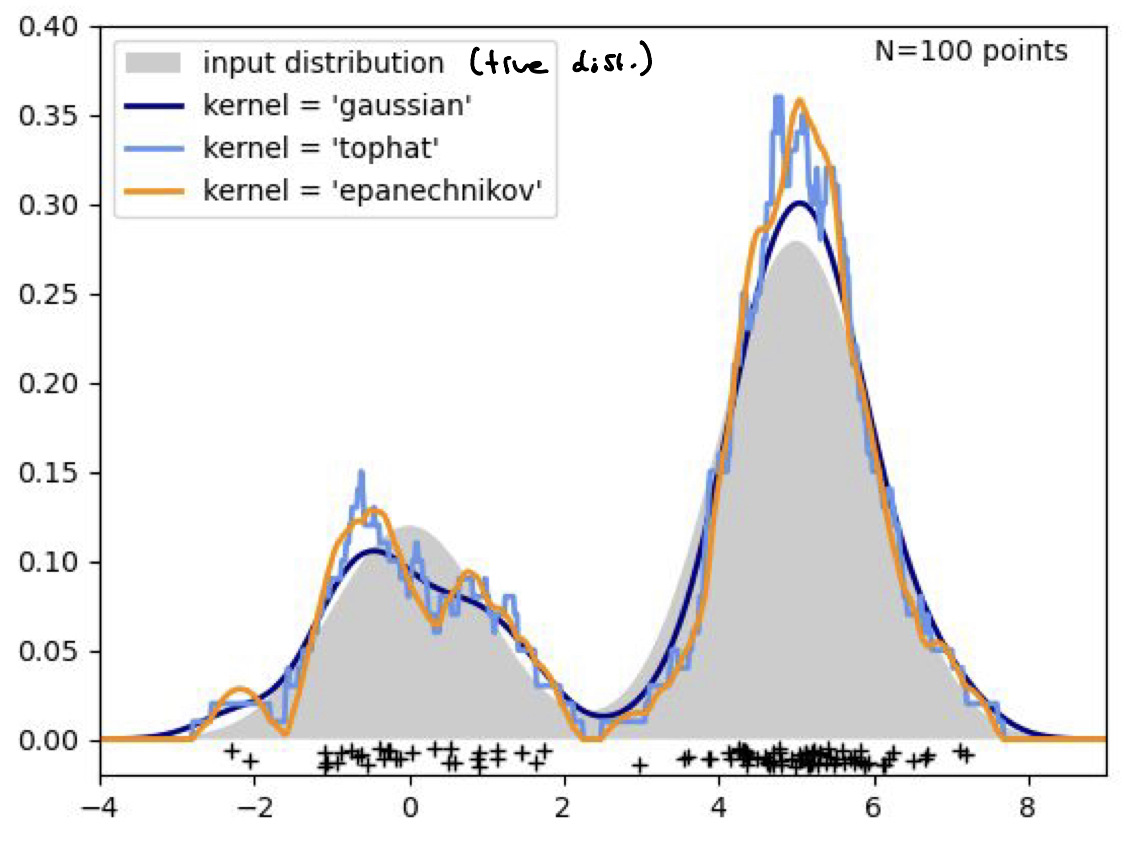 | The true distribution, with samples drawn from it shown at the bottom, we generate the KDE and can see that it closely recreates the input distribution.  |
| ----- | ------ | 




# k-Nearest Neighbors (k-NN)

### Idea: 

Create a cell around each point. For a point x_i, for every other point inside its cell, x_i is the nearest neighbor.

So, for a new query point, if you want to know what class it belongs to, you can look at the k-nearest neighbors and take a majority vote.

In [79]:
# VORONI FUNCTION
def voronoi(D: pd.DataFrame):
    '''
        D: DataFrame with columns 'x1' and 'x2'
        returns: 2D array of indices (closest point in D)
    '''
    # 1 - Create a grid of points
    x_min, x_max = D['x1'].min() - 1, D['x1'].max() + 1
    y_min, y_max = D['x2'].min() - 1, D['x2'].max() + 1

    n = 100     # n = how detailed the grid is
    x = np.linspace(x_min, x_max, n)
    y = np.linspace(y_min, y_max, n)
    X, Y = np.meshgrid(x, y)    # tuple of ndarrays

    # 2 - For every point in the 2D grid, find the distance to the closest point in D
    VOR = np.zeros(X.shape)                                     # 2D array of indices (closest point in D)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x,y = X[i, j], Y[i, j]                                  # point on grid
            dist = np.sqrt((D['x1'] - x)**2 + (D['x2'] - y)**2)     # distance to every point in D
            VOR[i, j] = np.argmin(dist)                         # index of the closest point in D
    return VOR

In [119]:
# EX. DATA #1
n = 10
np.random.seed(20)
D = pd.DataFrame({
    'x1': np.random.uniform(0, 10, n),
    'x2': np.random.uniform(0, 10, n),
    'label': np.random.choice([0, 1], n)
})

In [ ]:
# VORONI DIAGRAM EXAMPLE

vor = voronoi(D)
plt.scatter(x1, x2, c='black')
plt.imshow(vor, extent=[0, 10, 0, 10], origin='lower')

## k-NN Algorithm

Complexity: $O(ndk)$

- classify based on each point in the training set
- for each, compute the distance (d components)
- find the k-nearest neighbors

In [214]:
# KNN Algorithm

def EDist(x0,x1):
    '''
        x0: 1D array
        x1: 1D array
        returns: Euclidean distance between x0 and x1
    '''
    return np.sqrt(sum((x0 - x1)**2))

def createKNN_Classifier(D: pd.DataFrame, d: int, k: int) -> callable:
    '''
        @param D: DataFrame with d-dimension features, and label column at index d.
        @param d: dimension of the feature space
        @param k: number of neighbors
        @returns: True if d is in the majority class of its k nearest neighbors
    '''
    def KNN_Classifier(x: np.ndarray):
        # 1 - Compute the distance between x and every point in D
        dists = [ EDist(D.iloc[i, :d], x) for i in D.index ]
        # 2 - Get smallest k-distances
        idx = np.argsort(dists)
        k_nearest = D.iloc[idx[:k], d]  # assumes: label col at index d
        # 3 - get the majority class
        maj_class = k_nearest.mode()[0]
        return maj_class
    return KNN_Classifier

In [ ]:
# TESTING KNN ON EX. 1 DATA

# Create a set of new points to classify:
n = 5
np.random.seed(10)
x = pd.DataFrame({
    'x1': np.random.uniform(0, 10, n),
    'x2': np.random.uniform(0, 10, n)
})

def interactKNN(k:int):
    KNN_classifier = createKNN_Classifier(D, d=2, k=k)
    classes = [ KNN_classifier(x.iloc[i, :]) for i in x.index ]
    # plot the OG data
    plt.scatter(D['x1'], D['x2'], c=D['label'], cmap=plt.cm.get_cmap('bwr'))
    # plot the query points, and their new classes:
    plt.scatter(x['x1'], x['x2'], c='black', edgecolor=['red' if c == 1 else 'blue' for c in classes], s=10)

interact(interactKNN, k=(1, 10, 1))

### Bias Variance Tradeoff 

|                   | **Small k**   | **Large k**   |
| ---               | ---           | ---           |
| **Variance**      | High          | Low           |
| **Bias**          | Low           | High          |
| **Fit to Data**   | overfit       | underfit      |
| **Models**        | noise         | underlying distribution |


In [ ]:
# EX. DATA #2 - Seperable, but not with a straight line:
n = 200
x1 = np.random.uniform(0, 10, n)
x2 = np.random.uniform(0, 10, n)

D = pd.DataFrame({
    'x1': x1,
    'x2': x2,
    'label': [ x1[i] + x2[i] > 10 + 3*np.sin(2*np.pi / 5 * x1[i])   for i in range(n)]
})

def interactK_KNN(k:int):
    # SHOWS HOW K changes the decision boundary (overfitting vs. underfitting)
    KNN = createKNN_Classifier(D, d=2,k=k)
    n = 10
    X,Y = np.meshgrid(np.linspace(0, 10, n), np.linspace(0, 10, n))
    CLASS = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            CLASS[i, j] = KNN([X[i, j], Y[i, j]])

    plt.scatter(x1, x2, c=D['label'], cmap=plt.cm.get_cmap('bwr'))
    plt.imshow(CLASS, extent=[0, 10, 0, 10], origin='lower', cmap=plt.cm.get_cmap('bwr', 2), alpha=0.3)
    plt.title(f'How k affects the decision boundary')

interact(interactK_KNN, k=(1, 100, 1), continuous_update=False)


### Upper bound on KNN's Error rate

With enough data, the accuracy of KNN (w' $k=1$) is near that of an optimal classifier (Bayes):

$$
    \lim_{n \to \infty} \epsilon_{KNN} < 2 \epsilon_{Bayes}(1-\epsilon_{Bayes})
$$

#### Bayes (Optimal) Classifier

Best case scenario if you know the distribution of the data ($\red{P}$)

Outputs the most likely class. 

$$
    \hat{y} = \text{argmax}_c P[y=c | x, \red{P}]
$$

The error rate is simply: 

$$
    \epsilon_{Bayes} = E[1 - \text{max}_c P[y=c | x, \red{P}]]
$$

#### But ...

As \# dimensions ($d$) increases, \# samples ($n$) needed for the lower bound ($2\epsilon_{bayes}$) increases exponentially.

# $k$-Means Clustering 

### Common Case: 

**Given:** 

1. $D$: $n$ observations in $d$ dimensions
2. Function, $f$: 
- Symmetric
- Gives distance between two points
- Its a measure of similarity, e.g. $f(x_i, x_j) = 1$ if $x_i = x_j$


**Goal:**

A partition of subsets: 

$$
    C = \{C_1, C_2, \ldots, C_k\}
$$

Such that each observation is in **exactly one** subset. 

**Idea:**

$f$ tells us something about the similarity between points. How exatly do we "similarity" is up to us.

### Objective: Minimize Cost of Clusters

**Centroid of a cluster:**

$$
    \mu_j = \frac{1}{|C_j|} \sum_{x_i \in C_j} x_i
$$

It's the "mean" of the cluster. 

**Cost of a cluster:**


$$
    \text{min}_{C} \sum_{i=1}^k \frac{1}{|C_j|} \sum_{x_i \in C_j} f(x_i, \mu_j)
$$

Where 

- $f=||x_i - \mu_j||^2_2$ (L2 norm)

## Lyod's Algorithm

In [248]:
def costFunction(x_i, x_j):
    '''Euclidean distance between two points'''
    return np.linalg.norm(x_i - x_j)

def getClusterCentroid(C: np.ndarray):
    '''
        Calculate the centroid of a cluster.
        Returns 1d numpy array with the same # rows as C.
    '''
    return np.mean(C, axis=0)

def LyodsAlgorithm(D: np.ndarray, k):
    n, d = D.shape
    C = None
    # P_C[i] = cluster that D[i] belongs to
    np.random.seed(None)
    P_C = np.random.choice(k, n)    # Randomly initialize k cluster centroids
    new_clusters = True
    while new_clusters:
        new_clusters = False
        # 1) get the clusters centroids, using the P_C map:
        C = [ D[P_C == i] for i in range(k) ]
        # 1) get the centroids
        cents = [ getClusterCentroid(C_i) for C_i in C ]
        # 2) for each point, assign it to the closest centroid
        for i in range(n):
            closest_centroid_num = np.argmin(
                [ costFunction(D[i], cent) for cent in cents ]
            )
            if P_C[i] != closest_centroid_num:
                new_clusters = True
                P_C[i] = closest_centroid_num
    return C

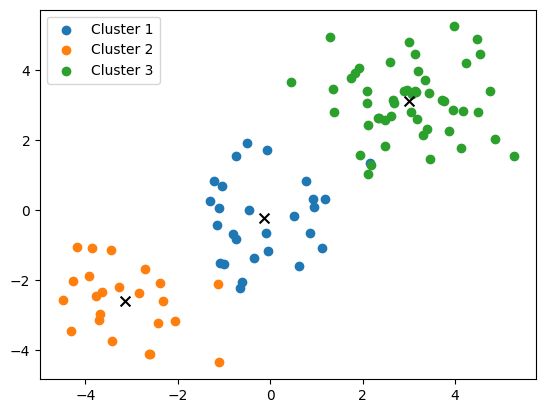

In [265]:
# TESTING: artficial dataset, n=100, d=2, k = 3

np.random.seed(0)
n = 100
X = np.random.randn(n, 2)
Y = np.zeros(n)

# Create 3 distinct clusters:
X[:n//2] += 3

X[n//2:n-n//4] -= 3
Y[n//2:n-n//4] = 1

Y[n-n//4:] = 2

# D is a numpy array with 2 columns, X and Y:
D = np.column_stack((X, Y))

# Run Lyods Algorithm

CLUSTS = LyodsAlgorithm(D, 3)

# Plot results
for C in CLUSTS:
    plt.scatter(C[:, 0], C[:, 1])

plt.legend([ f'Cluster {i+1}' for i, C in enumerate(CLUSTS) ])

# plot the centroids
for C in CLUSTS:
    cent = getClusterCentroid(C)
    plt.scatter(cent[0], cent[1], c='black', s=50, marker='x')


### Limitations: 

1. How to choose $k$
2. The # iterations needed and the outcome depends on how clusters are randomly assigned. 